In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import pandas as pd
import datetime
import psutil
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tools

import warnings
warnings.filterwarnings('ignore')

## Experiment 2
- ASTER dems
- using processed outputs from ragmac_xdem/scripts/main_experiment2.py
- these dems are all already aligned, but can add check and reproject as needed, e.g. https://github.com/GlacioHack/geoprofile/blob/main/geoprofile/core/core.py#L122

### Stack arrays and parse dates

In [3]:
input_dir = '../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dems = sorted(glob.glob(os.path.join(input_dir, '*.tif')))

In [4]:
dems[:3]

['../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2000.54825814_coreg.tif',
 '../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2000.69885137_coreg.tif',
 '../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.22515096_coreg.tif']

In [5]:
arrays = []
dt_list = []

for i in dems[:]:
    src = gu.georaster.Raster(i)
    masked_array = src.data
    
    arrays.append(masked_array)
    
    date_time = float(os.path.basename(i).split('_')[1])
    dt_list.append(date_time)
    
ma_stack = np.ma.vstack(arrays)

dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list]
date_list = [i.date() for i in dt_list]

### Plot gallery

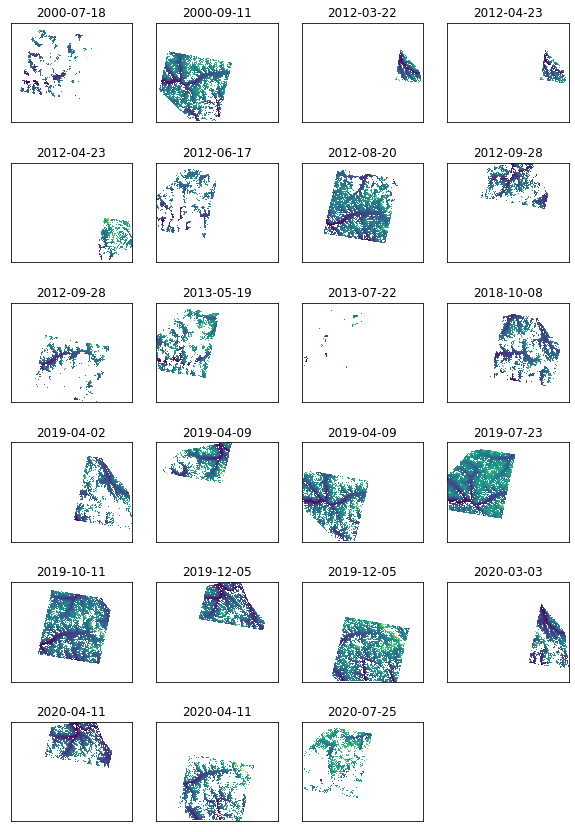

In [6]:
tools.plot_gallery(ma_stack, date_list)

### Pick point from time series

In [7]:
# point = (1650,1650)
point = (2000,1650)

In [8]:
# tools.plot_timelapse(ma_stack, 
#                      point=point, 
#                      titles_list=dt_list)

In [9]:
selection = []

for i in range(len(ma_stack)):
    selection.append(ma_stack[i][point[1]][point[0]])
    
selection_array = np.ma.array(selection)[:, np.newaxis]

In [10]:
available_data = selection_array.data[~selection_array.mask]
available_dates = np.array(dt_list)[:, np.newaxis][~selection_array.mask]

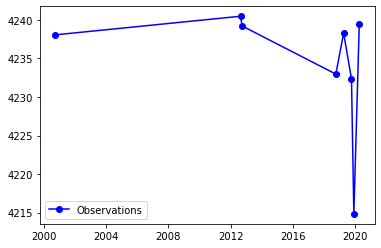

In [11]:
plt.plot(available_dates, 
         available_data, 
         marker='o',c='b', 
         label="Observations")
plt.legend();

### Fit linear models

In [12]:
from sklearn import linear_model

In [13]:
X = np.ma.array([tools.convert_date_time_to_decimal_date(i) for i in dt_list])[:, np.newaxis].data

X_train = X[~selection_array.mask][:, np.newaxis]
y_train = selection_array.data[~selection_array.mask][:, np.newaxis]

#### Linear regression

In [14]:
m = linear_model.LinearRegression()
m.fit(X_train, y_train)
slope = m.coef_
intercept = m.intercept_
predicted = m.predict(X)

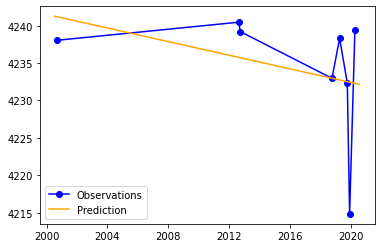

In [15]:
fig,ax = plt.subplots()
ax.plot(available_dates, y_train, marker='o',c='b', 
         label="Observations")
ax.plot(date_list, predicted, c='orange', 
         label="Prediction")

ax.legend();

#### RANSAC

In [16]:
m = linear_model.RANSACRegressor()
m.fit(X_train, y_train)
slope = m.estimator_.coef_
intercept = m.estimator_.intercept_
predicted = m.predict(X)

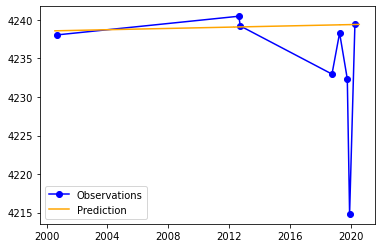

In [17]:
fig,ax = plt.subplots()
ax.plot(available_dates, y_train, marker='o',c='b', 
         label="Observations")
ax.plot(date_list, predicted, c='orange', 
         label="Prediction")

ax.legend();

#### Theil Sen

In [18]:
m = linear_model.TheilSenRegressor()
m.fit(X_train, y_train.squeeze())
slope = m.coef_
intercept = m.intercept_
predicted = m.predict(X)

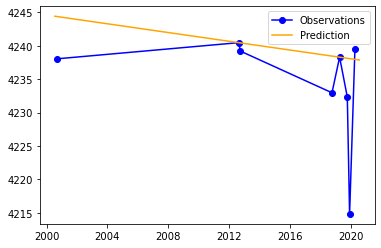

In [19]:
fig,ax = plt.subplots()
ax.plot(available_dates, y_train, marker='o',c='b', 
         label="Observations")
ax.plot(date_list, predicted, c='orange', 
         label="Prediction")

ax.legend();

#### Stepwise linear interpolation

In [20]:
from scipy.interpolate import interp1d

In [21]:
m = interp1d(X_train.squeeze(), y_train.squeeze(), kind='linear')
x_new = np.arange(X_train.squeeze()[0], X_train.squeeze()[-1], 0.1)
predicted = m(x_new)

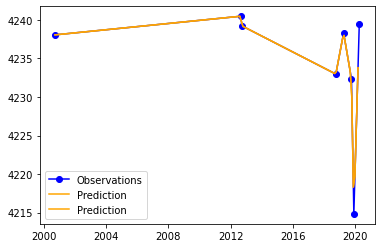

In [22]:
fig,ax = plt.subplots()
x_new_dates = [tools.convert_decimal_date_to_date_time(i) for i in x_new]
ax.plot(available_dates, y_train, marker='o',c='b', 
         label="Observations")
ax.plot(x_new_dates, predicted, c='orange', 
         label="Prediction")

ax.legend();

### Gaussian Process Regression
- Adapted from [Mauna Loaexample](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) 
- Using CO2 kernel design for now. 
- [Example adding error](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)
- Likely better to design custom kernel as was done in Hugonnet et al. 2021
- May be possible to use an automated approach to design the kernel, e.g. through docomposing dominant modes and iterative performance evaluation on kernels modeling each mode.


In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

In [24]:
v = 10.0
long_term_trend_kernel = v**2 * RBF(length_scale=v)

seasonal_kernel = (
    2.0 ** 2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5 ** 2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1 ** 2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1 ** 2, noise_level_bounds=(1e-5, 1e5)
)

glacier_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

In [25]:
# df = pd.read_csv('../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/coreg_stats.txt')
# bias = df['med_coreg'].mean()

In [26]:
gaussian_process = GaussianProcessRegressor(kernel=glacier_kernel, 
                                            normalize_y=True, 
#                                             alpha=bias,
                                            n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

GaussianProcessRegressor(kernel=10**2 * RBF(length_scale=10) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=9, normalize_y=True)

### Make prediction

In [27]:
start_date = '2000-01-01'
end_date = '2023-01-01'

dt ='M' # monthly frequency
# dt ='3M'
# dt ='6M'

d = pd.date_range(start_date,end_date, 
              freq=dt)

X_test = d.to_series().apply([tools.convert_date_time_to_decimal_date]).values

In [28]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, 
                                                           return_std=True)

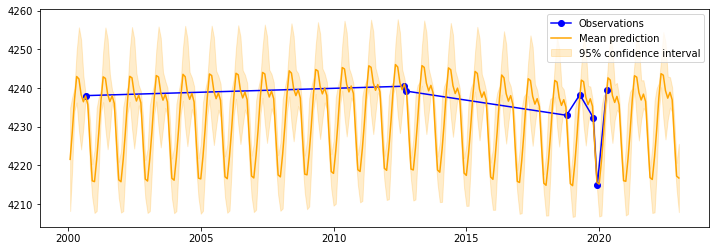

In [29]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(X_train, y_train, marker='o',c='b', label="Observations")
ax.plot(X_test, mean_prediction,c='orange', label="Mean prediction")
ax.fill_between(
    X_test.squeeze(),
    mean_prediction.squeeze() - 1.96 * std_prediction,
    mean_prediction.squeeze() + 1.96 * std_prediction,
    alpha=0.2,
    label="95% confidence interval",
    color='orange'
)
ax.legend();

### Extract points along glacier centerline and compare prediction

In [30]:
import geopandas as gpd

In [31]:
fn = '../../data/raw/experiment_2/PK_Baltoro/14_rgi60_asw_wgs84_utm43n_baltoro_selection.shp'

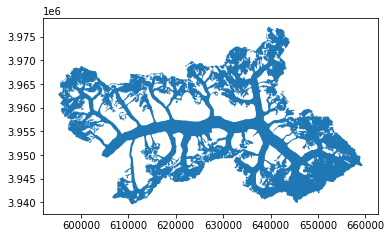

In [32]:
df = gpd.read_file(fn)
df = df[df['Area'] == df['Area'].max()]
df.plot();

In [39]:
rgi_id = df['RGIId'].values[0]

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
3,RGI60-14.06794,G076405E35742N,20010721,-9999999,76.4047,35.7416,14,2,809.109,3385,...,296,63448,0,0,0,0,3,9,Baltoro Glacier,"POLYGON ((639758.038 3977025.001, 639674.977 3..."


In [76]:
def OGGM_get_centerline(rgi_id):
    from oggm import cfg, utils, workflow, graphics
    cfg.initialize(logging_level='CRITICAL')
    rgi_ids = [rgi_id]
    
    cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-centerlines', reset=True)
    
    # We start from prepro level 3 with all data ready - note the url here
    base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/centerlines/qc3/pcp2.5/no_match/'
    gdirs = workflow.init_glacier_directories(rgi_ids, 
                                              from_prepro_level=3, 
                                              prepro_border=40, 
                                              prepro_base_url=base_url)
    gdir_cl = gdirs[0]
    center_lines = gdir_cl.read_pickle('centerlines')
    
    p = pathlib.Path('./rgi_tmp/')
    p.mkdir(parents=True, exist_ok=True)
    utils.write_centerlines_to_shape(gdir_cl, path='./rgi_tmp/tmp.shp')
    gdf = gpd.read_file('./rgi_tmp/tmp.shp')
    
    shutil.rmtree('./rgi_tmp/')
    
    return gdf
    

In [77]:
import os
import shutil
import pathlib

In [78]:
gdf = OGGM_get_centerline(rgi_id)

<AxesSubplot:>

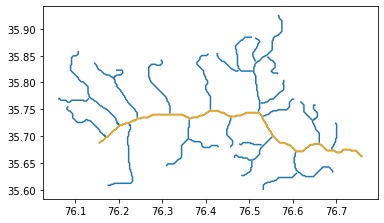

In [79]:
fig,ax = plt.subplots()
gdf.plot(ax=ax)
gdf[gdf['LE_SEGMENT'] == gdf['LE_SEGMENT'].max()].plot(ax=ax, color='orange')

### Build model for each pixel

In [92]:
import concurrent

In [95]:
def get_array_coordinate_tuples(array):
    coordinates=[]
    for x in range(0,array.shape[0]):
        for y in range(0,array.shape[1]):
            coordinates.append((x,y))
    return list(coordinates)

In [96]:
def GPR_model(X_train, y_train, custom_kernel):
    
    gaussian_process_model = GaussianProcessRegressor(kernel=custom_kernel, 
                                                      normalize_y=True, 
                                                      n_restarts_optimizer=9)
    
    gaussian_process_model = gaussian_process_model.fit(X_train, y_train)
    
    return gaussian_process_model

In [97]:
def GPR_predict(gaussian_process_model, X):
    mean_prediction, std_prediction = gaussian_process_model.predict(X, return_std=True)
    
    return mean_prediction, std_prediction

In [98]:
def extract_time_series_at_coordinates(coords,masked_3d_array, date_time_as_float_array):
    
    selection = []
    
    for i in range(len(masked_3d_array)):
        selection.append(masked_3d_array[i][coords[0]][coords[1]])
    
    selection_array = np.ma.array(selection)[:, np.newaxis]
    
    X_train = date_time_as_float_array[~selection_array.mask][:, np.newaxis]
    y_train = selection_array.data[~selection_array.mask]
    
    return X_train, y_train
    

In [99]:
def GPR_run(args):
    
    X_train, y_train, X_pred, custom_kernel = args 
    
    if len(X_train) > 3:
        gaussian_process_model = GPR_model(X_train, y_train, custom_kernel)
        mean_prediction, std_prediction = GPR_predict(gaussian_process_model, X_pred)
        mean_prediction, std_prediction = mean_prediction.reshape(-1,1), std_prediction.reshape(-1,1)
        
    else:
        mean_prediction = np.full(X_pred.shape, 0)
        std_prediction  = np.full(X_pred.shape, 0)
    
    return mean_prediction, std_prediction
    

In [100]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [101]:
def process(stack,custom_kernel):
    coordinates = get_array_coordinate_tuples(stack.data[0])
    date_time_as_float_array = np.ma.array([tools.convert_date_time_to_decimal_date(i) for i in dt_list])[:, np.newaxis].data
    
    args = []
    for coords in coordinates:
        X_train, y_train= extract_time_series_at_coordinates(coords,stack,date_time_as_float_array)
        args.append([X_train, y_train, X_pred, custom_kernel])

    mean_prediction_all = np.array([]).reshape(-1,1)
    std_prediction_all = np.array([]).reshape(-1,1)
    with ThreadPoolExecutor(max_workers=psutil.cpu_count(logical=True)) as executor:
        for i in executor.map(GPR_run, args):
            mean_prediction, std_prediction = i
            mean_prediction_all = np.append(mean_prediction_all,mean_prediction.reshape(-1,1))
            std_prediction_all = np.append(std_prediction_all,std_prediction.reshape(-1,1))
            
    return mean_prediction_all , std_prediction_all
# process()

In [102]:
start_date = '2000-01-01'
end_date = '2023-01-01'

dt ='M' # monthly frequency
# dt ='3M'
# dt ='6M'

d = pd.date_range(start_date,end_date, 
              freq=dt)

X_pred = d.to_series().apply([tools.convert_date_time_to_decimal_date]).values

In [103]:
ma_stack_test = ma_stack[:, 1600:1650:10, 1600:1650:10]

In [105]:
%%time
mean_prediction_all , std_prediction_all = process(ma_stack_test,glacier_kernel)

CPU times: user 18.6 ms, sys: 3.42 ms, total: 22 ms
Wall time: 21.6 ms


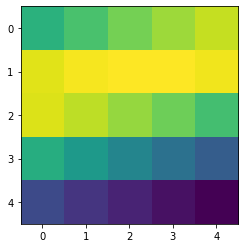

In [46]:
plt.imshow(mean_prediction_all.reshape(276,ma_stack_test.shape[1],ma_stack_test.shape[2])[0])

In [48]:
# tools.plot_timelapse(mean_prediction_all.reshape(276,ma_stack_test.shape[1],ma_stack_test.shape[2]), X_pred)

## Lazy load dems

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import pandas as pd
import datetime
import psutil
import pathlib
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

import tools

import warnings
warnings.filterwarnings('ignore')

### Get time stamps from DEM file names

In [19]:
input_dir = '../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dems = sorted(glob.glob(os.path.join(input_dir, '*.tif')))

dt_list = []

for i in dems[:]:
    date_time = float(os.path.basename(i).split('_')[1])
    dt_list.append(date_time)

dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list]

### Write DEMs to NetCDF

In [20]:
# for i,v in enumerate(dems):
#     out_fn = str(pathlib.Path(dems[i]).with_suffix("")) + ".nc"
#     ds = tools.xr_read_tif(dems[i])
#     ds = ds.assign_coords({"time": dt_list[i]}) 
#     ds = ds.expand_dims("time")
#     ds.to_netcdf(out_fn)

### Lazy load stacked time series

In [21]:
ds = xr.open_mfdataset('../../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/*.nc',
                       chunks=1000)

In [22]:
ds

,Array,Chunk
Bytes,1.06 GiB,3.81 MiB
Shape,"(23, 3176, 3878)","(1, 1000, 1000)"
Count,759 Tasks,368 Chunks
Type,float32,numpy.ndarray


### Get coordinates

In [23]:
def get_coordinate_tuples(ds):
    x_coords = ds.coords['x'].values
    y_coords = ds.coords['y'].values
    coords=[]
    for x in x_coords:
        for y in y_coords:
            coords.append((x,y))
    return np.array(coords)

In [24]:
coords = get_coordinate_tuples(ds)

In [25]:
coords[0]

array([ 564561.3449, 4005203.1441])

### Get time stamps as float

In [26]:
X_train = np.ma.array([tools.convert_date_time_to_decimal_date(i) for i in dt_list])[:, np.newaxis].data

### Create prediction time series

In [27]:
def create_prediction_time_x_axis(start_date = '2000-01-01',
                                 end_date = '2023-01-01',
                                 dt ='M'):
    #M  = monthly frequency
    #3M = every 3 months
    #6M = every 6 months
    d = pd.date_range(start_date,end_date,freq=dt)
    X_train = d.to_series().apply([tools.convert_date_time_to_decimal_date]).values
    return X_train

In [28]:
X = create_prediction_time_x_axis(start_date = '2000-01-01',
                                  end_date = '2023-01-01',
                                  dt ='M')

In [29]:
X[0]

array([2000.08487337])

### Define GPR kernel and functions

In [30]:
import dask

In [31]:
def GPR_kernel():
    v = 10.0
    long_term_trend_kernel = v**2 * RBF(length_scale=v)

    seasonal_kernel = (
        2.0 ** 2
        * RBF(length_scale=100.0)
        * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
    )

    irregularities_kernel = 0.5 ** 2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

    noise_kernel = 0.1 ** 2 * RBF(length_scale=0.1) + WhiteKernel(
        noise_level=0.1 ** 2, noise_level_bounds=(1e-5, 1e5)
    )

    kernel = (
        long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
    )
    return kernel

In [32]:
def GPR_model(X_train, y_train, custom_kernel):
    
    gaussian_process_model = GaussianProcessRegressor(kernel=custom_kernel, 
                                                      normalize_y=True, 
                                                      n_restarts_optimizer=9)
    
    gaussian_process_model = gaussian_process_model.fit(X_train, y_train)
    
    return gaussian_process_model

In [33]:
def GPR_predict(gaussian_process_model, X):
    mean_prediction, std_prediction = gaussian_process_model.predict(X, return_std=True)
    
    return mean_prediction, std_prediction

In [34]:
def GPR_run(X_train, y_train, X, custom_kernel):
    
    if len(X_train) > 3:
        gaussian_process_model = GPR_model(X_train, y_train, custom_kernel)
        mean_prediction, std_prediction = GPR_predict(gaussian_process_model, X)
        mean_prediction, std_prediction = mean_prediction.reshape(-1,1), std_prediction.reshape(-1,1)
        
    else:
        mean_prediction = np.full(X.shape, 0)
        std_prediction  = np.full(X.shape, 0)
    
    return mean_prediction, std_prediction

### Parallelize with Dask

In [54]:
@dask.delayed(nout=2)
def remove_nans_from_array(y_train, X_train):
    mask = ~np.isnan(y_train)
    y_train_tmp = y_train[mask]
    X_train_tmp = X_train[mask]
    return y_train_tmp, X_train_tmp

In [55]:
@dask.delayed(nout=2)
def extract_time_series_at_coordinates_from_ds(coords_tuple,ds,X_train):
    
    y_train_tmp = ds.sel(x=coords_tuple[0],y=coords_tuple[1])['band1'].values
    
    y_train_tmp, X_train_tmp = remove_nans_from_array(y_train_tmp, X_train)
    
    return y_train_tmp, X_train_tmp

In [56]:
custom_kernel = GPR_kernel()

In [57]:
mean_prediction_all = dask.delayed(np.array([]))
std_prediction_all = dask.delayed(np.array([]))

test = coords[::10000]
for coords_tuple in test:
    y_train_tmp, X_train_tmp = extract_time_series_at_coordinates_from_ds(coords_tuple,
                                                                          ds,
                                                                          X_train)
    
    mean_prediction, std_prediction = GPR_run(y_train_tmp, X_train_tmp, X, custom_kernel)
    
    mean_prediction_all = mean_prediction_all.append(mean_prediction)
    std_prediction_all = std_prediction_all.append(std_prediction)
    
    

In [18]:
# std_prediction_all.compute()

In [55]:
def GPR_extract_time_series(ds, coords, X_train):
    args = []
#     c = 0
    for coords_tuple in coords:
        X_train_tmp, y_train_tmp = extract_time_series_at_coordinates_from_ds(coords_tuple,
                                                                              ds,
                                                                              X_train)
        args.append([X_train_tmp, y_train_tmp, X, custom_kernel])
#         c +=1
#         if c>1000:
#             break
    return args

In [ ]:
def process(stack,custom_kernel):
    coordinates = get_array_coordinate_tuples(stack.data[0])
    date_time_as_float_array = np.ma.array([tools.convert_date_time_to_decimal_date(i) for i in dt_list])[:, np.newaxis].data
    
    args = []
    for coords in coordinates:
        X_train, y_train= extract_time_series_at_coordinates(coords,stack,date_time_as_float_array)
        args.append([X_train, y_train, X_pred, custom_kernel])

    mean_prediction_all = np.array([]).reshape(-1,1)
    std_prediction_all = np.array([]).reshape(-1,1)
    with ThreadPoolExecutor(max_workers=psutil.cpu_count(logical=True)) as executor:
        for i in executor.map(GPR_run, args):
            mean_prediction, std_prediction = i
            mean_prediction_all = np.append(mean_prediction_all,mean_prediction.reshape(-1,1))
            std_prediction_all = np.append(std_prediction_all,std_prediction.reshape(-1,1))
            
    return mean_prediction_all , std_prediction_all

In [127]:
remove_nans(y_train, X_train)

(array([3946.2107, 3948.6697, 3945.5845, 3948.3794, 3946.0688, 3951.9229,
        3954.504 , 3952.2178, 3960.34  , 3951.4028, 3933.1372, 3951.1138],
       dtype=float32),
 array([[2000.54825814],
        [2000.69885137],
        [2012.46335551],
        [2012.63857803],
        [2012.74536571],
        [2013.38122053],
        [2018.76999737],
        [2019.27171876],
        [2019.5591808 ],
        [2019.77820842],
        [2019.92880184],
        [2020.27993231]]))

In [ ]:
np.isnan(ds.sel(x=x_coords[1650],y=y_coords[1650])['band1'].values)
ds.sel(x=x_coords[1650],y=y_coords[1650])['band1'].values